# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   - **Jumlah Baris**: Minimal 1000 baris untuk memastikan dataset cukup besar untuk analisis yang bermakna.
   - **Tipe Data**: Harus mengandung data **kategorikal** dan **numerikal**.
     - *Kategorikal*: Misalnya jenis kelamin, kategori produk.
     - *Numerikal*: Misalnya usia, pendapatan, harga.

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak boleh digunakan.

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

In [24]:
data = "/content/Dataset_clustering.csv"
df = pd.read_csv(data)

df.shape

(5000, 4)

In [25]:
df.head()

,age,balance,housing,loan
0,58,2143,yes,no
1,44,29,yes,no
2,33,2,yes,yes
3,47,1506,yes,no
4,33,1,no,no


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

In [26]:
df.describe()

,age,balance
count,5000.000000,5000.00000
mean,40.415400,957.59300
std,9.412192,2462.15561
min,20.000000,-3313.00000
25%,33.000000,56.00000
50%,40.000000,304.00000
75%,47.000000,894.50000
max,61.000000,58544.00000


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   age      5000 non-null   int64 
 1   balance  5000 non-null   int64 
 2   housing  5000 non-null   object
 3   loan     5000 non-null   object
dtypes: int64(2), object(2)
memory usage: 156.4+ KB


In [28]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumerical features: {numerical_features}")
print(f"\nCategorical features: {categorical_features}")


Numerical features: ['age', 'balance']

Categorical features: ['housing', 'loan']


Numerical Features Distributions

<Figure size 1600x1000 with 0 Axes>

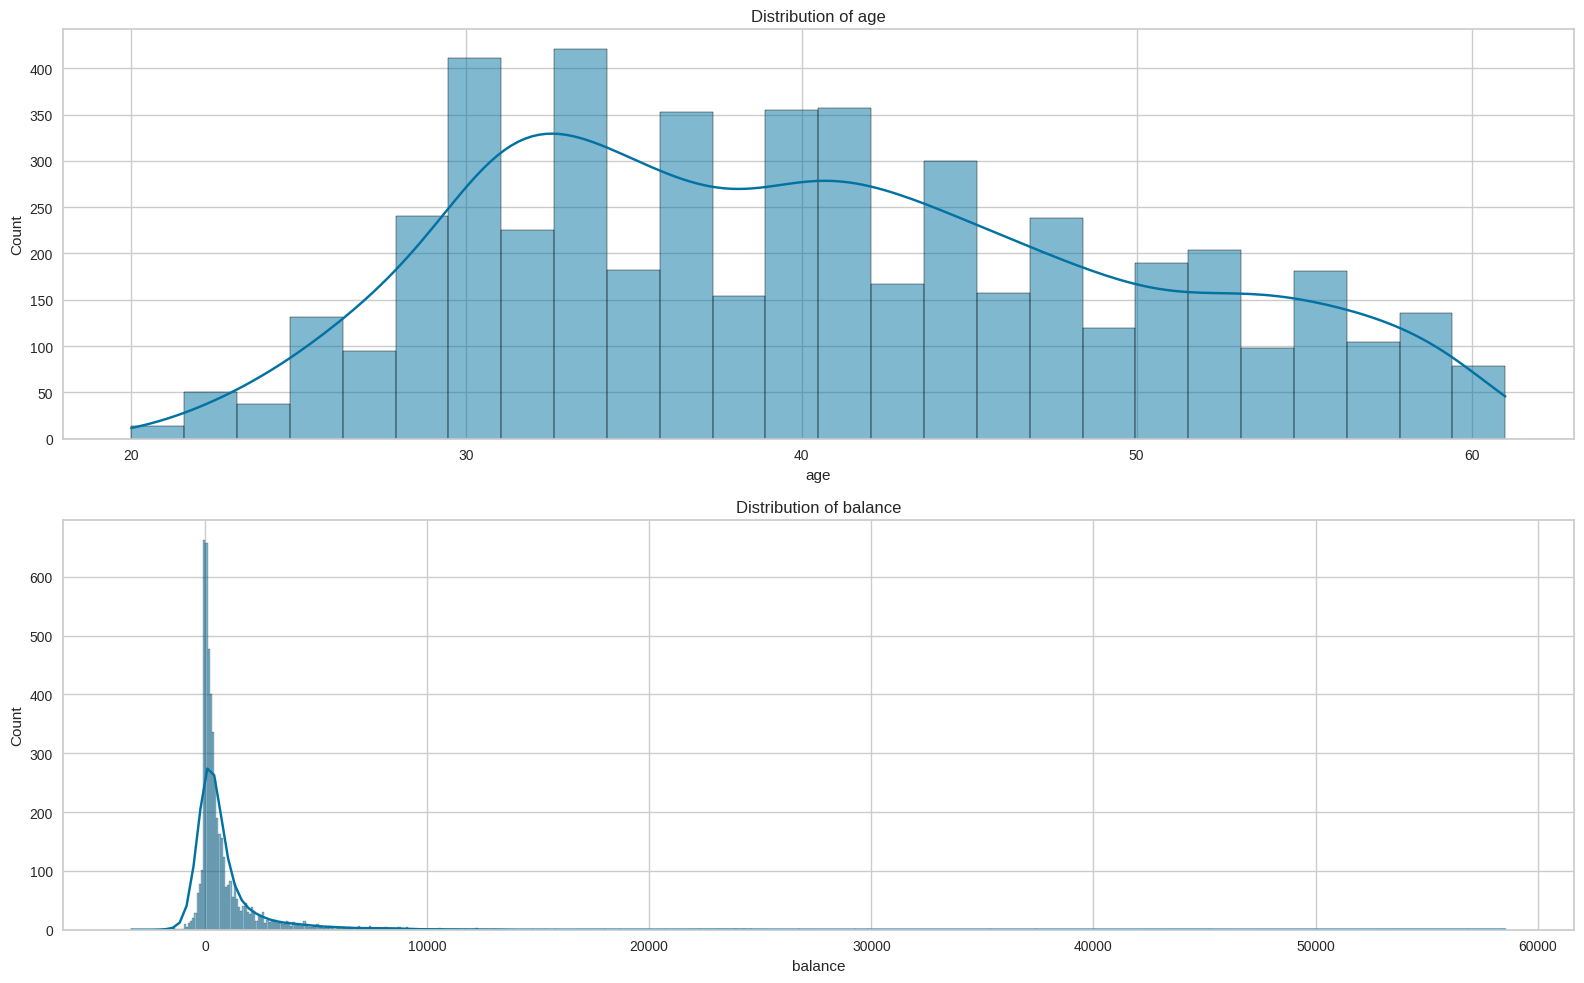

In [29]:
plt.figure(figsize=(16, 10))
plt.figure(figsize=(16, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(len(numerical_features), 1, i+1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()

Correlation antara numerical features

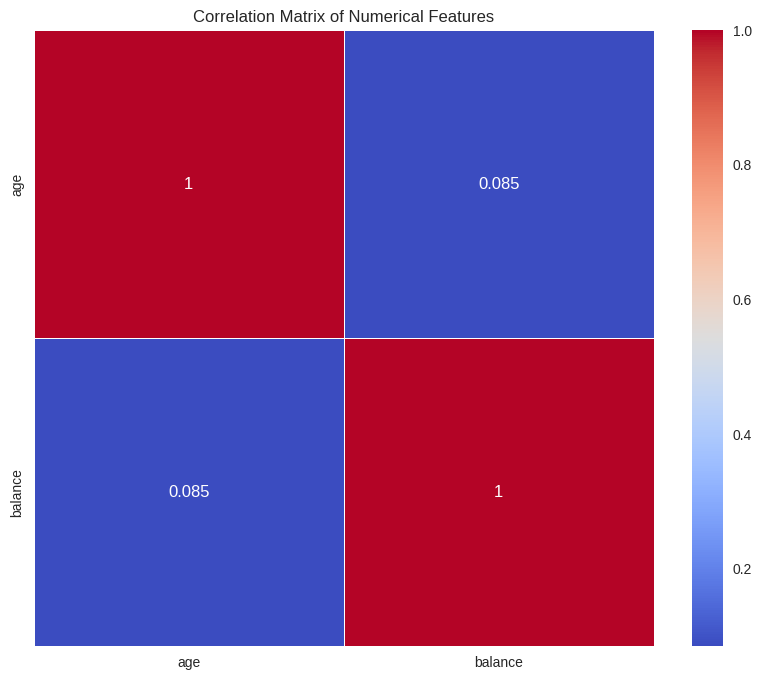

In [30]:
plt.figure(figsize=(10, 8))
correlation_matrix = df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Categorical Features Distribution

<Figure size 1800x1500 with 0 Axes>

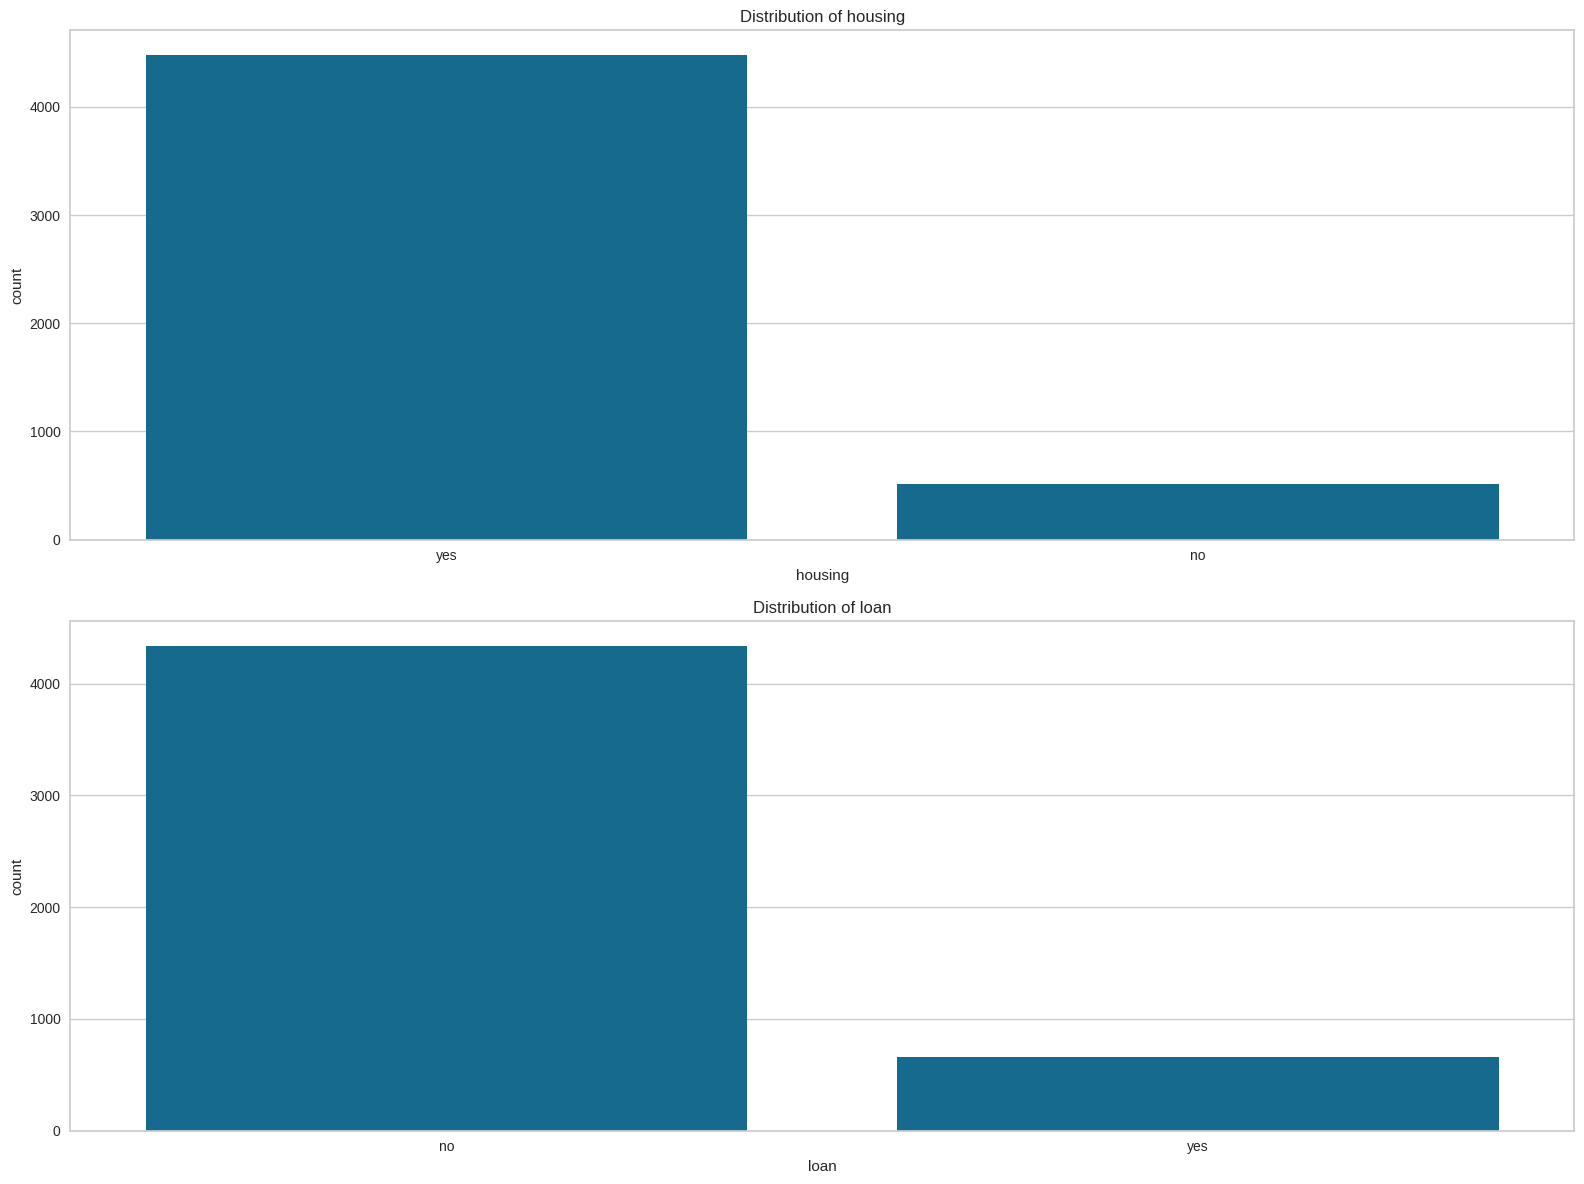

In [31]:
plt.figure(figsize=(18, 15))
plt.figure(figsize=(16, 12))
for i, feature in enumerate(categorical_features):
    plt.subplot(len(categorical_features), 1, i+1)
    sns.countplot(x=feature, data=df)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah.

In [32]:
# Copy of original data

df_preprocessed = df.copy()
df_preprocessed.head()

,age,balance,housing,loan
0,58,2143,yes,no
1,44,29,yes,no
2,33,2,yes,yes
3,47,1506,yes,no
4,33,1,no,no


Mengatasi nilai outlier

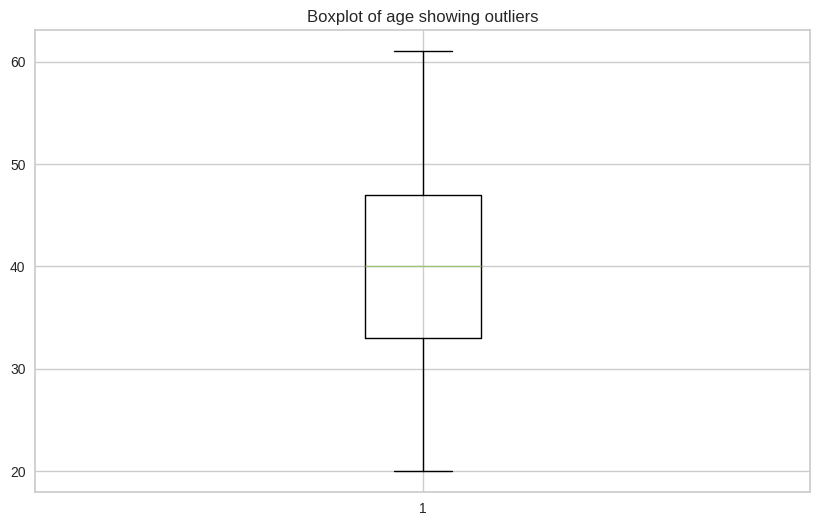

Capped outliers in age at boundaries: [12.0, 68.0]


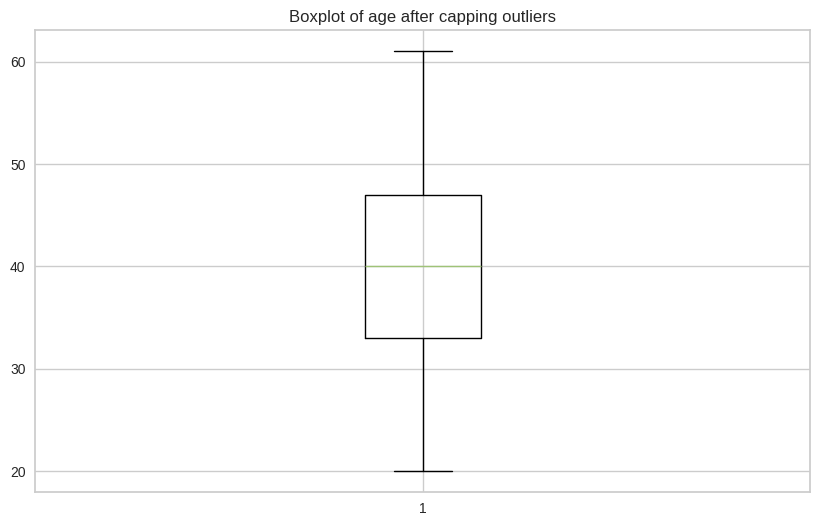

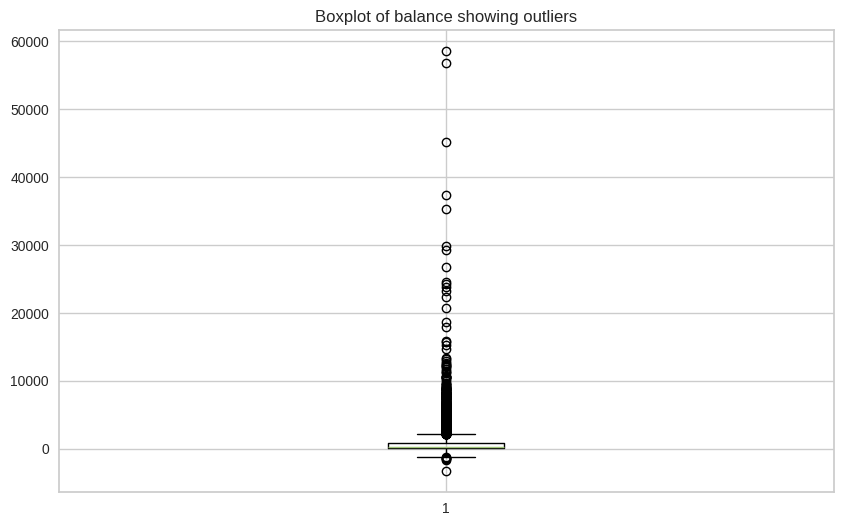

Capped outliers in balance at boundaries: [-1201.75, 2152.25]


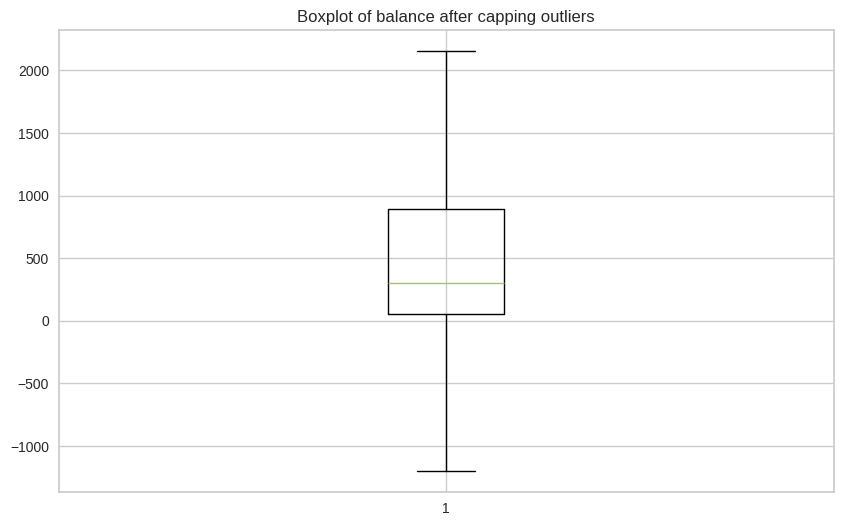

In [33]:
for col in numerical_features:
    # Calculate Q1, Q3, and IQR
    Q1 = df_preprocessed[col].quantile(0.25)
    Q3 = df_preprocessed[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    outliers = df_preprocessed[(df_preprocessed[col] < lower_bound) | (df_preprocessed[col] > upper_bound)][col]
    outlier_count = len(outliers)

    plt.figure(figsize=(10, 6))
    plt.boxplot(df_preprocessed[col])
    plt.title(f'Boxplot of {col} showing outliers')
    plt.show()

    df_preprocessed[col] = np.where(df_preprocessed[col] < lower_bound, lower_bound, df_preprocessed[col])
    df_preprocessed[col] = np.where(df_preprocessed[col] > upper_bound, upper_bound, df_preprocessed[col])
    print(f"Capped outliers in {col} at boundaries: [{lower_bound}, {upper_bound}]")

    plt.figure(figsize=(10, 6))
    plt.boxplot(df_preprocessed[col])
    plt.title(f'Boxplot of {col} after capping outliers')
    plt.show()

Feature Scaling

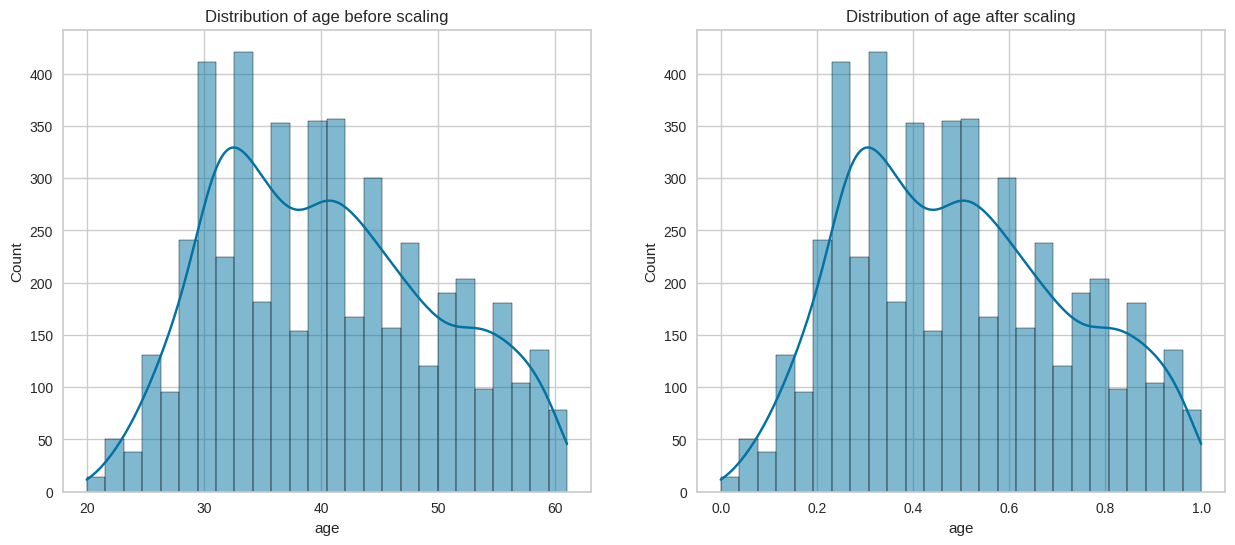

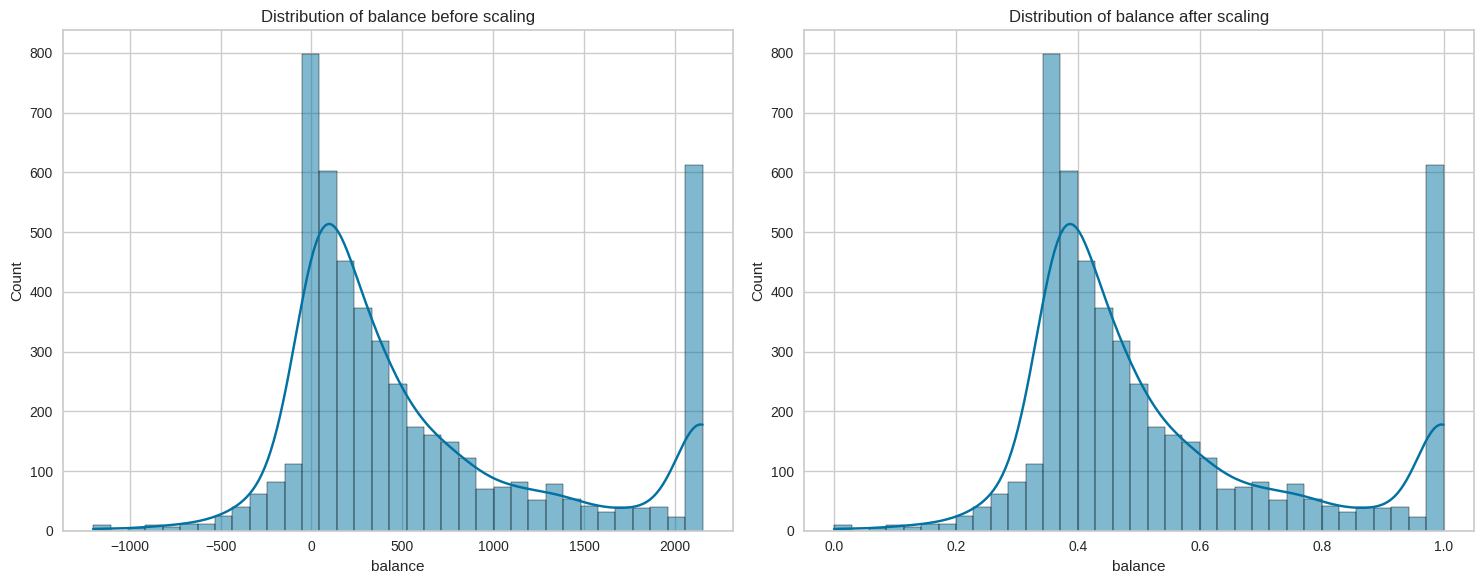

In [34]:
# Apply just MinMaxScaler
minmax_scaler = MinMaxScaler()
df_preprocessed_scaled = df_preprocessed.copy()
df_preprocessed_scaled[numerical_features] = minmax_scaler.fit_transform(df_preprocessed[numerical_features])

# Save scaler for later use
scaler_fit = minmax_scaler

# Visualize before and after scaling
for col in numerical_features:
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(df_preprocessed[col], kde=True)
    plt.title(f'Distribution of {col} before scaling')

    plt.subplot(1, 2, 2)
    sns.histplot(df_preprocessed_scaled[col], kde=True)
    plt.title(f'Distribution of {col} after scaling')

plt.tight_layout()

Digunakan minmax scaling karena:
- Memberikan bobot yang sama untuk semua fitur
- Mencegah fitur dengan skala besar mendominasi perhitungan saat clustering

In [35]:
# One-hot encoding for categorical cluster features
encoder_cluster = OneHotEncoder(sparse_output=False, drop='first')
encoded_cluster_features = pd.DataFrame(encoder_cluster.fit_transform(df_preprocessed[categorical_features]))

# Set column names for encoded cluster features
encoded_cluster_names = []
for i, feature in enumerate(categorical_features):
    categories = encoder_cluster.categories_[i][1:]  # Exclude first category
    for category in categories:
        encoded_cluster_names.append(f"{feature}_{category}")
encoded_cluster_features.columns = encoded_cluster_names

In [36]:
# Combine numerical and encoded categorical features for clustering
X_cluster = pd.concat([df_preprocessed_scaled[numerical_features], encoded_cluster_features], axis=1)

# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, Anda membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan. Berikut adalah **rekomendasi** tahapannya.
1. Pilih algoritma clustering yang sesuai.
2. Latih model dengan data menggunakan algoritma tersebut.

In [37]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_cluster)

## **b. Evaluasi Model Clustering**

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.
2. Hitung Silhouette Score sebagai ukuran kualitas cluster.

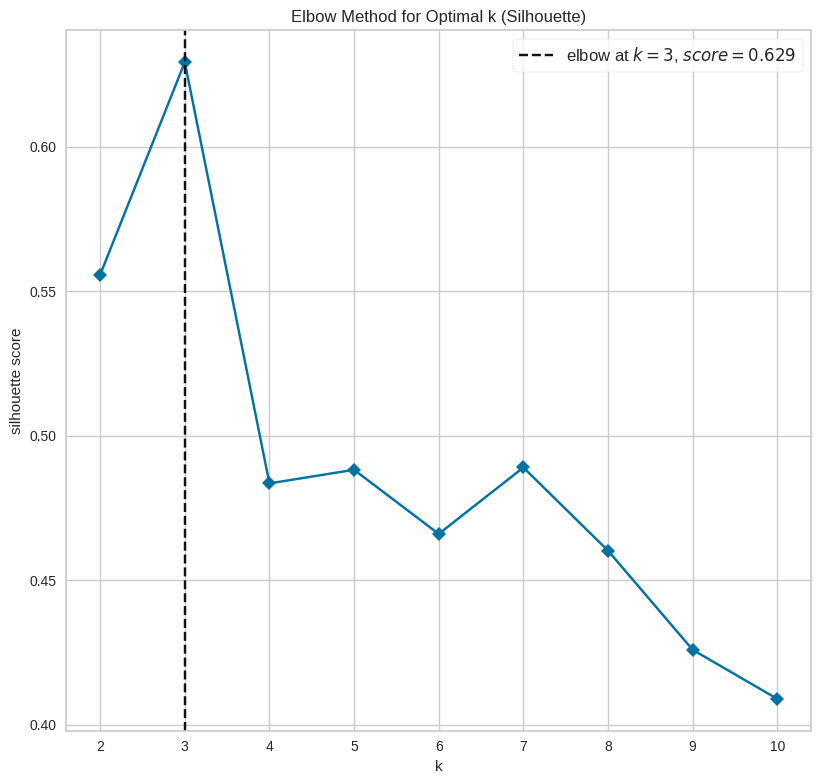

In [38]:
# Menentukan nilai k optimal
plt.figure(figsize=(16, 8))

# Elbow Method Visualizer for Silhouette Score
plt.subplot(1, 2, 2)
visualizer = KElbowVisualizer(
    KMeans(random_state=42, n_init=10),
    k=(2, 11),
    metric='silhouette',
    timings=False
)
visualizer.fit(X_cluster)
visualizer.finalize()
plt.title('Elbow Method for Optimal k (Silhouette)')

plt.tight_layout()

In [39]:
# Apply KMeans with optimal k
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_cluster)

# Calculate silhouette score
silhouette_avg = silhouette_score(X_cluster, clusters)
print(f"For n_clusters = 2, the silhouette score is {silhouette_avg:.4f}")

For n_clusters = 2, the silhouette score is 0.6293


## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

In [40]:
# Apply KMeans to original data
print("\nApplying KMeans to original data...")
kmeans_original = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters_original = kmeans_original.fit_predict(X_cluster)
silhouette_original = silhouette_score(X_cluster, clusters_original)
print(f"Silhouette score on original data: {silhouette_original:.4f}")

# Apply PCA for dimensionality reduction
print("\nApplying PCA for dimensionality reduction...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by 2 principal components: {sum(explained_variance)*100:.2f}%")

# Apply KMeans to PCA-reduced data
print("\nApplying KMeans to PCA-reduced data...")
kmeans_pca = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters_pca = kmeans_pca.fit_predict(X_pca)
silhouette_pca = silhouette_score(X_pca, clusters_pca)
print(f"Silhouette score on PCA-reduced data: {silhouette_pca:.4f}")


Applying KMeans to original data...
Silhouette score on original data: 0.6293

Applying PCA for dimensionality reduction...
Explained variance by 2 principal components: 67.08%

Applying KMeans to PCA-reduced data...
Silhouette score on PCA-reduced data: 0.9477


## **d. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

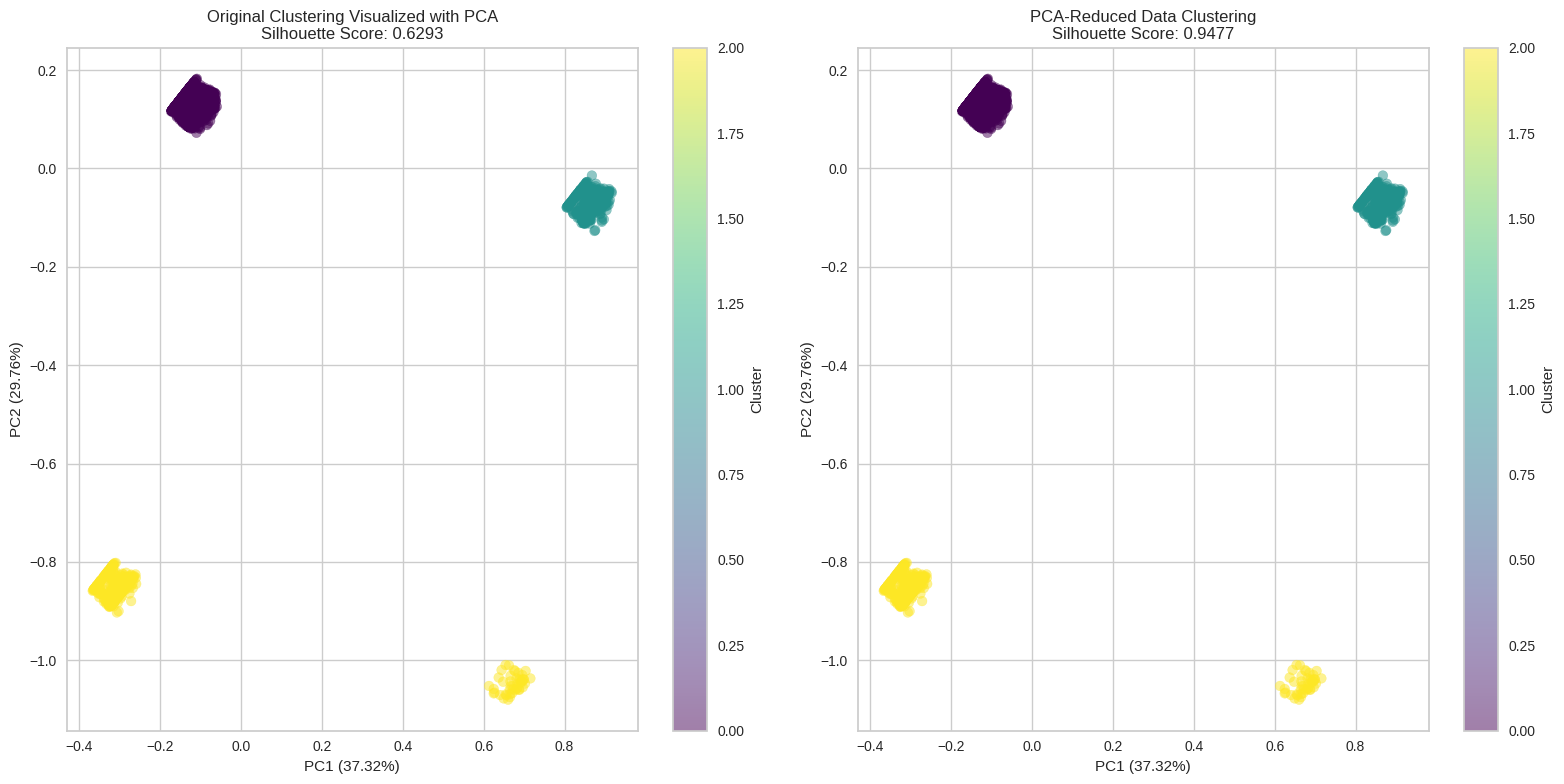

In [41]:
plt.figure(figsize=(16, 8))

# Original data clustering visualized with PCA
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_original, cmap='viridis', alpha=0.5)
plt.title(f'Original Clustering Visualized with PCA\nSilhouette Score: {silhouette_original:.4f}')
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)')
plt.colorbar(label='Cluster')

# PCA-reduced data clustering
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_pca, cmap='viridis', alpha=0.5)
plt.title(f'PCA-Reduced Data Clustering\nSilhouette Score: {silhouette_pca:.4f}')
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

## **e. Analisis dan Interpretasi Hasil Cluster**

### Interpretasi Target

**Tutorial: Melakukan Inverse Transform pada Data Target Setelah Clustering**

Setelah melakukan clustering dengan model **KMeans**, kita perlu mengembalikan data yang telah diubah (normalisasi, standarisasi, atau label encoding) ke bentuk aslinya. Berikut adalah langkah-langkahnya.

---

**1. Tambahkan Hasil Label Cluster ke DataFrame**
Setelah mendapatkan hasil clustering, kita tambahkan label cluster ke dalam DataFrame yang telah dinormalisasi.

```python
df_normalized['Cluster'] = model_kmeans.labels_
```

Lakukan Inverse Transform pada feature yang sudah dilakukan Labelisasi dan Standararisasi. Berikut code untuk melakukannya:
label_encoder.inverse_transform(X_Selected[['Fitur']])

Lalu masukkan ke dalam kolom dataset asli atau membuat dataframe baru
```python
df_normalized['Fitur'] = label_encoder.inverse_transform(df_normalized[['Fitur']])
```
Masukkan Data yang Sudah Di-Inverse ke dalam Dataset Asli atau Buat DataFrame Baru
```python
df_original['Fitur'] = df_normalized['Fitur']
```

In [42]:
# Get centroid
original_centroids = kmeans_original.cluster_centers_
pca_centroids = kmeans_pca.cluster_centers_

In [43]:
# Map PCA centroids back to original feature space
pca_centroids_original_space = pca.inverse_transform(pca_centroids)

In [44]:
# Initialize dataframes to store the centroids
original_centroids_df = pd.DataFrame(original_centroids, columns=X_cluster.columns)
pca_centroids_df = pd.DataFrame(pca_centroids_original_space, columns=X_cluster.columns)

# Separate numerical and categorical features in centroids
numerical_centroids_original = original_centroids_df[numerical_features].values
numerical_centroids_pca = pca_centroids_df[numerical_features].values

In [45]:
# Function to interpret one-hot encoded features
def interpret_encoded_features(centroid_df, categorical_features, encoder):
    interpretations = {}

    start_idx = 0
    for i, feature in enumerate(categorical_features):
        categories = encoder.categories_[i]
        n_categories = len(categories)

        # Get the encoded values for this feature (but we need to reconstruct the dropped first category)
        encoded_values = centroid_df.iloc[:, len(numerical_features) + start_idx:len(numerical_features) + start_idx + n_categories - 1].values

        # For each centroid
        for centroid_idx in range(encoded_values.shape[0]):
            # Reconstructed value (including first category that was dropped)
            reconstructed = np.zeros(n_categories)
            reconstructed[1:] = encoded_values[centroid_idx]
            reconstructed[0] = 1 - np.sum(reconstructed[1:])  # First category is 1 minus the sum of others

            # Find the most likely category based on highest probability
            most_likely_category_idx = np.argmax(reconstructed)
            most_likely_category = categories[most_likely_category_idx]

            if centroid_idx not in interpretations:
                interpretations[centroid_idx] = {}

            interpretations[centroid_idx][feature] = most_likely_category

        start_idx += n_categories - 1

    return interpretations

# Interpret categorical features for both models
categorical_interpretations_original = interpret_encoded_features(original_centroids_df, categorical_features, encoder_cluster)
categorical_interpretations_pca = interpret_encoded_features(pca_centroids_df, categorical_features, encoder_cluster)

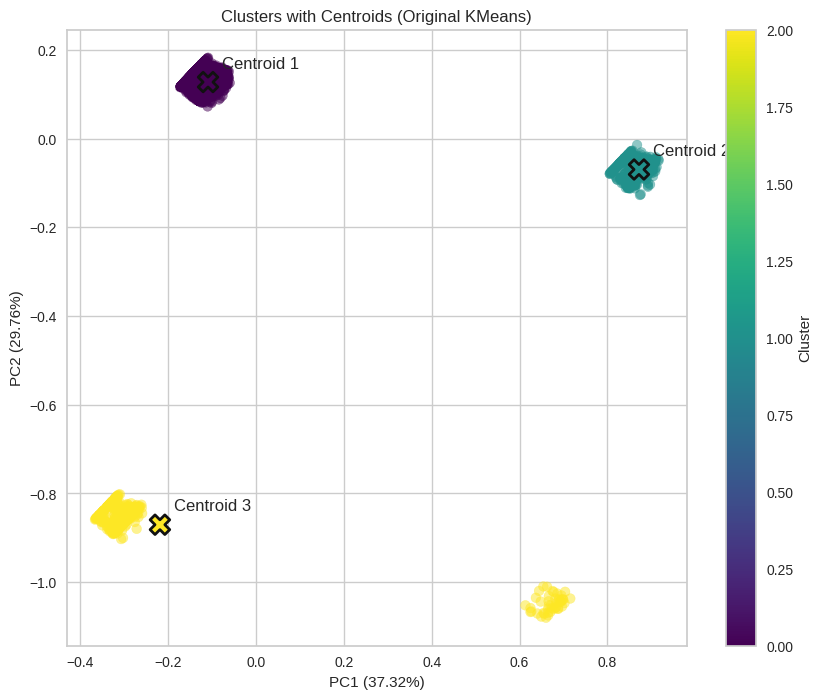

In [46]:
# Plot original data with centroids
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_original, cmap='viridis', alpha=0.5)

# Plot original centroids transformed to PCA space
original_centroids_pca = pca.transform(original_centroids)
plt.scatter(original_centroids_pca[:, 0], original_centroids_pca[:, 1],
            c=range(len(original_centroids)), marker='X', s=200,
            cmap='viridis', edgecolors='k', linewidth=2)

# Add centroid labels
for i, (x, y) in enumerate(original_centroids_pca):
    plt.annotate(f'Centroid {i+1}', (x, y), fontsize=12,
                 xytext=(10, 10), textcoords='offset points')

plt.title('Clusters with Centroids (Original KMeans)')
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)')
plt.colorbar(label='Cluster')
plt.show()

### Inverse Data Jika Melakukan Normalisasi/Standardisasi

Inverse Transform untuk Data yang Distandarisasi
Jika data numerik telah dinormalisasi menggunakan StandardScaler atau MinMaxScaler, kita bisa mengembalikannya ke skala asli:
```python
df_normalized[['Fitur_Numerik']] = scaler.inverse_transform(df_normalized[['Fitur_Numerik']])
```

In [47]:
# Inverse transform the numerical features to get original scale
numerical_centroids_original_unscaled = scaler_fit.inverse_transform(numerical_centroids_original)
numerical_centroids_pca_unscaled = scaler_fit.inverse_transform(numerical_centroids_pca)

Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Berikut adalah **rekomendasi** tahapannya.
1. Analisis karakteristik tiap cluster berdasarkan fitur yang tersedia (misalnya, distribusi nilai dalam cluster).
2. Berikan interpretasi: Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis? Apakah ada pola tertentu yang bisa dimanfaatkan?

In [48]:
# Create final interpretation dataframes
def create_centroid_summary(numerical_unscaled, numerical_features, categorical_interp, cluster_name):
    results = []

    for i in range(numerical_unscaled.shape[0]):
        row = {'Cluster': f'{cluster_name} {i+1}'}

        # Add numerical features
        for j, feature in enumerate(numerical_features):
            row[feature] = numerical_unscaled[i, j]

        # Add categorical features
        for feature, value in categorical_interp[i].items():
            row[feature] = value

        results.append(row)

    return pd.DataFrame(results)

# Create summaries
original_summary = create_centroid_summary(
    numerical_centroids_original_unscaled,
    numerical_features,
    categorical_interpretations_original,
    'Original'
)

pca_summary = create_centroid_summary(
    numerical_centroids_pca_unscaled,
    numerical_features,
    categorical_interpretations_pca,
    'PCA'
)

# Combine both summaries
final_summary = pd.concat([original_summary, pca_summary])
print(final_summary)

      Cluster        age     balance housing loan
0  Original 1  40.382269  619.785022     yes   no
1  Original 2  39.334421  478.815661     yes  yes
2  Original 3  41.942085  531.580116      no   no
0       PCA 1  40.348800  639.307192     yes   no
1       PCA 2  38.219477  389.900192     yes  yes
2       PCA 3  43.511493  490.989199      no   no


In [49]:
# Example interpretation for each cluster
for i in range(len(original_summary)):
    row = original_summary.iloc[i]
    print(f"\nCluster {i+1} Interpretation:")

    # Interpret age
    if row['age'] < 35:
        age_group = "Usia dewasa"
    elif row['age'] < 65:
        age_group = "Paruh Baya"
    else:
        age_group = "Lansia"

    # Interpret balance
    if row['balance'] < 350:
        balance_level = "saldo rendah"
    elif row['balance'] < 550:
        balance_level = "saldo sedang"
    else:
        balance_level = "saldo tinggi"

    # Create interpretation
    housing_status = "dengan" if row['housing'] == 'yes' else "tanpa"
    loan_status = "dengan" if row['loan'] == 'yes' else "tanpa"

    interpretation = f"{age_group} dengan {balance_level}, {housing_status} pinjaman rumah, dan {loan_status} pinjaman pribadi."
    print(interpretation)


Cluster 1 Interpretation:
Paruh Baya dengan saldo tinggi, dengan pinjaman rumah, dan tanpa pinjaman pribadi.

Cluster 2 Interpretation:
Paruh Baya dengan saldo sedang, dengan pinjaman rumah, dan dengan pinjaman pribadi.

Cluster 3 Interpretation:
Paruh Baya dengan saldo sedang, tanpa pinjaman rumah, dan tanpa pinjaman pribadi.


Tulis hasil interpretasinya di sini (PCA).
1. Cluster 1: Usia paruh baya dengan saldo tinggi, pinjaman rumah, tanpa pinjaman pribadi
2. Cluster 2: Usia paruh baya dengan saldo sedang, pinjaman rumah, dan pinjaman pribadi
3. Cluster 3: Usia paruh baya dengan saldo sedang, tanpa pinjaman rumah, dan tanpa pinjaman pribadi

# Contoh interpretasi [TEMPLATE]
# Analisis Karakteristik Cluster dari Model KMeans

Berikut adalah analisis karakteristik untuk setiap cluster yang dihasilkan dari model KMeans.

## Cluster PCA 1:
- **Rata-rata Age (year):** 40  
- **Rata-rata Balance/Saldo ($):** 639.307
- **Pinjaman rumah:** Ya
- **Pinjaman pribadi:** Tidak
- **Analisis:** Cluster ini mencakup nasabah usia paruh baya dengan saldo rekening tertinggi yang memiliki pinjaman rumah, tetapi tidak memiliki pinjaman pribadi. Nasabah ini kemungkinan mengalokasikan uangnya untuk membayar pinjaman rumah tersebut

## Cluster PCA 2:
- **Rata-rata Age (year):** 38
- **Rata-rata Balance/Saldo ($):** 389.9
- **Pinjaman rumah:** Ya
- **Pinjaman pribadi:** Ya
- **Analisis:** Cluster ini menunjukkan nasabah paruh baya dengan saldo terendah. Nasabah cluster ini memiliki pinjaman ganda berupa pinjaman pribadi dan pinjaman rumah, yang bisa menjelaskan saldo rekening mereka yang rendah dikarenakan pinjaman ganda tersebut

## Cluster PCA 3:
- **Rata-rata Age (year):** 43
- **Rata-rata Balance/Saldo ($):** 490.989
- **Pinjaman rumah:** Tidak
- **Pinjaman pribadi:** Tidak
- **Analisis:** Cluster ini terdiri dari nasabah paruh baya yang tidak memiliki pinjaman apa pun. Meskipun saldo mereka lebih rendah daripada cluster 1, karena mereka tidak memiliki tanggungan pinjaman memungkinkan situasi keuangan mereka yang lebih stabil

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [50]:
# Add cluster labels from PCA-reduced clustering to the original dataset
df_with_clusters = df.copy()
df_with_clusters['cluster'] = clusters_original

# Save the labeled dataset to CSV
df_with_clusters.to_csv('Dataset_inisiasi.csv', index=False)

In [51]:
df_with_clusters.head()

,age,balance,housing,loan,cluster
0,58,2143,yes,no,0
1,44,29,yes,no,0
2,33,2,yes,yes,1
3,47,1506,yes,no,0
4,33,1,no,no,2
